<a href="https://colab.research.google.com/github/the-redlord/comp455-project-team5/blob/master/Team5_finalv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Step 1: import

import tensorflow as tf
from tensorflow import keras

import os

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.constraints import maxnorm
from keras.layers import  Conv2D, MaxPooling2D, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())
tf.config.list_physical_devices('GPU')

TensorFlow version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? True


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# GDrive Import

In [2]:
# copy data from gdrive

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !ls /content/drive/MyDrive/C455FinalProject/

In [4]:
# !cp -R /content/drive/MyDrive/C455FinalProject/ /content/

# Github Files Import

In [5]:
if not os.path.isdir('C455FinalProject'):
    os.mkdir('C455FinalProject')

In [6]:
!ls

C455FinalProject  models  sample_data  Webapp.py


In [7]:
!wget -O /content/C455FinalProject/model_TermProject_Final.h5 https://github.com/the-redlord/comp455-project-team5/raw/master/model_TermProject_Final.h5

!wget -O /content/C455FinalProject/airplane.jpg https://github.com/the-redlord/comp455-project-team5/raw/master/airplane.jpg

!wget -O /content/C455FinalProject/cat.jpg https://github.com/the-redlord/comp455-project-team5/raw/master/cat.jpg

!wget -O /content/C455FinalProject/dog.jpg https://github.com/the-redlord/comp455-project-team5/raw/master/dog.jpg

--2020-12-13 08:04:42--  https://github.com/the-redlord/comp455-project-team5/raw/master/model_TermProject_Final.h5
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/the-redlord/comp455-project-team5/master/model_TermProject_Final.h5 [following]
--2020-12-13 08:04:42--  https://raw.githubusercontent.com/the-redlord/comp455-project-team5/master/model_TermProject_Final.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4514064 (4.3M) [application/octet-stream]
Saving to: ‘/content/C455FinalProject/model_TermProject_Final.h5’

/content/C455FinalP 100%[===================>]   4.30M  --.-KB/s    in 0.06s   

# Dataset Loading

In [8]:
#Load the dataset
(X_Train, Y_Train),(X_Test, Y_Test) = tf.keras.datasets.cifar10.load_data()

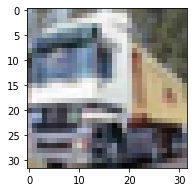

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(330+1+1)
plt.imshow(X_Train[1])
plt.show()
#print(Y_Train)

In [10]:
#Step 2: Data pre-processiing 


#Normalize the dataset
X_Train = X_Train.astype('float32')
X_Test = X_Test.astype('float32')

# X_Train = X_Train/255.0
# X_Test= X_Test/255.0

#z-score
mean = np.mean(X_Train,axis=(0,1,2,3))
std = np.std(X_Train,axis=(0,1,2,3))
X_Train = (X_Train-mean)/(std+1e-7)
X_Test = (X_Test-mean)/(std+1e-7)

In [11]:
X_Train.shape

(50000, 32, 32, 3)

In [12]:
#Now one hot encoding on Y_Test

#convert vectors into Binary class matrices

Y_Train=keras.utils.to_categorical(Y_Train)
Y_Test=keras.utils.to_categorical(Y_Test)

In [13]:
cifar_classes = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

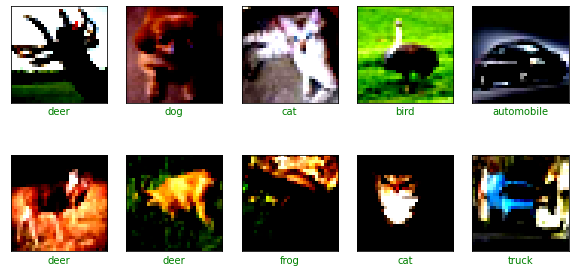

In [14]:
def show_random_examples(x,y,p):
  indices = np.random.choice(range(x.shape[0]),10,replace=False)
  x = x[indices]
  y = y[indices]
  p = p[indices]

  plt.figure(figsize=(10,5))
  for i in range(10):
    plt.subplot(2,5,1+i)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])

    # show correct prediction in green and wrong in red
    col ='green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
    plt.xlabel(cifar_classes[np.argmax(p[i])],color=col)
  plt.show()

show_random_examples(X_Train,Y_Train,Y_Train)

In [15]:
#Check the shape of Y_Train
num_classes = Y_Train.shape[1]

In [16]:
#Step 3: Model Creation

weightPath = 'C455FinalProject/model_TermProject_Final.h5'

def modelGen(weights_path=None):
    model = None

    if weights_path != None:
        model = tf.keras.models.load_model(weights_path)
    else:
        weight_decay = 1e-4

        model = Sequential()

        model.add(Input(shape=(32,32,3)))

        model.add(Conv2D(32,3,activation='elu',padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(Conv2D(32,3,activation='elu',padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        model.add(Conv2D(64,3,activation='elu',padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(Conv2D(64,3,activation='elu',padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.3))

        model.add(Conv2D(128,3,activation='elu',padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(Conv2D(128,3,activation='elu',padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.4))

        model.add(Flatten())

        model.add(Dense(128, activation='elu'))
        model.add(Dropout(0.2))

        model.add(Dense(10, activation= 'softmax'))    

    return model



#compile the model

opt_rms = RMSprop(lr=0.001,decay=1e-6)

model = modelGen(weightPath)

model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        2

In [18]:
history = None
if weightPath == None:
  history = model.fit(X_Train, Y_Train, validation_data=(X_Test,Y_Test), epochs=50, batch_size=128,callbacks=[
                tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                                                   save_best_only=True,save_weights_only=False,
                                                   monitor='val_accuracy')
              ])
  
  # plot accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  # plot loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  model.save('model_TermProject_Final.h5')

  print("Model saved!")

else:
  print("Model loaded from file!")

Model loaded from file!


In [19]:
#Step 4: Evaluation
loss, accuracy_= model.evaluate(X_Test, Y_Test)
print("Accuracy of this model is: ", accuracy_*100)

313/313 [==============================] - 1s 4ms/step - loss: 0.7068 - accuracy: 0.8533
Accuracy of this model is:  85.32999753952026


In [20]:
preds = model.predict(X_Test)

In [21]:
Y_Train.shape

(50000, 10)

In [22]:
preds.shape

(10000, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

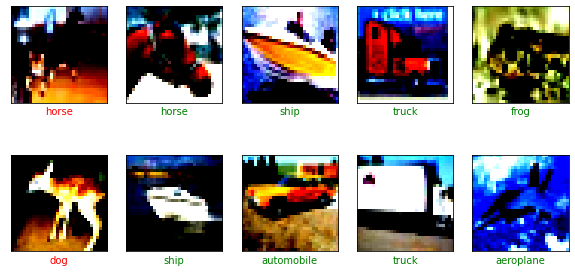

In [23]:
show_random_examples(X_Test,Y_Test,preds)

# Reading a single image and giving prediction

In [24]:
!ls

C455FinalProject  models  sample_data  Webapp.py


In [25]:
from google.colab.patches import cv2_imshow

In [26]:
imList = np.array([])

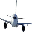

In [27]:
im = cv2.resize(cv2.imread('C455FinalProject/airplane.jpg'), (32, 32)).astype(np.float32)
cv2_imshow(im)
imList = np.append(imList,im)

In [28]:
imList = imList.reshape(1, 32, 32, 3)

In [29]:
imList.shape

(1, 32, 32, 3)

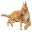

In [30]:
im = cv2.resize(cv2.imread('C455FinalProject/cat.jpg'), (32, 32)).astype(np.float32)
cv2_imshow(im)
imList = np.append(imList,im)

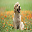

In [31]:
im = cv2.resize(cv2.imread('C455FinalProject/dog.jpg'), (32, 32)).astype(np.float32)
cv2_imshow(im)
imList = np.append(imList,im)

In [32]:
imList = imList.reshape(3, 32, 32, 3)

In [33]:
imList.shape

(3, 32, 32, 3)

In [34]:
# model.fit(datagen.flow(x_train, y_train, batch_size=32),
#           steps_per_epoch=len(x_train) / 32, epochs=epochs)

singlePred = model.predict(imList)

In [35]:
yImList = tf.keras.utils.to_categorical([0,3,5], num_classes=10)

In [36]:
def show_single_preds(x,y,p):
  for i in range(x.shape[0]):
    cv2_imshow(x[i])
    if np.argmax(y[i]) == np.argmax(p[i]):
      print(cifar_classes[np.argmax(p[i])])
      print("Correct")
    else:
      print(cifar_classes[np.argmax(p[i])])
      print("Incorrect")
    print("+++++++++++++++++++++++++++++")

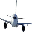

aeroplane
Correct
+++++++++++++++++++++++++++++


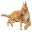

aeroplane
Incorrect
+++++++++++++++++++++++++++++


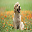

dog
Correct
+++++++++++++++++++++++++++++


In [37]:
show_single_preds(imList,yImList,singlePred)

# StreamLit

In [38]:
!pip install -q streamlit

In [39]:
!pip install pyngrok

SHOW CODE

In [40]:
%%writefile Webapp.py

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import streamlit as st
import json
import imutils
from io import BytesIO
from PIL import Image
import cv2
from keras.preprocessing import image


st.set_option('deprecation.showfileUploaderEncoding', False)
st.title("Image Classifier Using CIFAR10")
st.text("Providing URL of an image for image classification")

@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('C455FinalProject/model_TermProject_Final.h5')
  return model

with st.spinner('Loading Model Into Memory....'):
  model=load_model()

cifar_classes = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


uploaded_file = st.file_uploader("Choose an image...", type="jpg")
if uploaded_file is not None:
    img = Image.open(uploaded_file)
    img = img.convert('RGB')
    st.image(img, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    img = image.img_to_array(img)
    img = tf.image.central_crop(img, 0.8)
    img = np.asarray(img)
    im = cv2.resize(img, (32, 32)).astype(np.float32)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    x = im.reshape((1,32,32,3))
    mean = np.mean(x,axis=(0,1,2,3))
    std = np.std(x,axis=(0,1,2,3))
    x = (x-mean)/(std+1e-7)
    label = model.predict(x)
    st.header("Label:")
    st.subheader(cifar_classes[np.argmax(label)])
    # st.write('%s (%.2f%%)' % (label[1], label[2]*100))


Overwriting Webapp.py


In [41]:
!ls

C455FinalProject  models  sample_data  Webapp.py


In [42]:
!ngrok authtoken 1lFlzlRQs2iVnjK03RIjdhvz5ZF_5xaP65b24x3D6bFz6XmzE

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [43]:
!ngrok

NAME:
   ngrok - tunnel local ports to public URLs and inspect traffic

DESCRIPTION:
    ngrok exposes local networked services behinds NATs and firewalls to the
    public internet over a secure tunnel. Share local websites, build/test
    webhook consumers and self-host personal services.
    Detailed help for each command is available with 'ngrok help <command>'.
    Open http://localhost:4040 for ngrok's web interface to inspect traffic.

EXAMPLES:
    ngrok http 80                    # secure public URL for port 80 web server
    ngrok http -subdomain=baz 8080   # port 8080 available at baz.ngrok.io
    ngrok http foo.dev:80            # tunnel to host:port instead of localhost
    ngrok http https://localhost     # expose a local https server
    ngrok tcp 22                     # tunnel arbitrary TCP traffic to port 22
    ngrok tls -hostname=foo.com 443  # TLS traffic for foo.com to port 443
    ngrok start foo bar baz          # start tunnels from the configuration file

VERSI

In [44]:
from pyngrok import ngrok

In [45]:
#!nohub streamlit run Webapp.py

!streamlit run Webapp.py&>/dev/null&

In [46]:
!pgrep streamlit

269
427


In [47]:
publ_url = ngrok.connect(addr='8501')

In [48]:
publ_url

<NgrokTunnel: "http://b9924c25f270.ngrok.io" -> "http://localhost:8501">

In [49]:
# ngrok.kill()

In [50]:
# !ps -eaf | grep streamlit

In [51]:
# !kill 576